# ViT for Multi-label Image Classification with fastai

In [59]:
from fastai.vision.all import *
import pandas as pd
from fastai.vision.all import *
from pathlib import Path
from fastai.callback.all import Callback
from torch.utils.tensorboard import SummaryWriter
import os
from timm import create_model
from fastai.vision.learner import create_cnn_model
import timm
from torch import nn

## Data loading

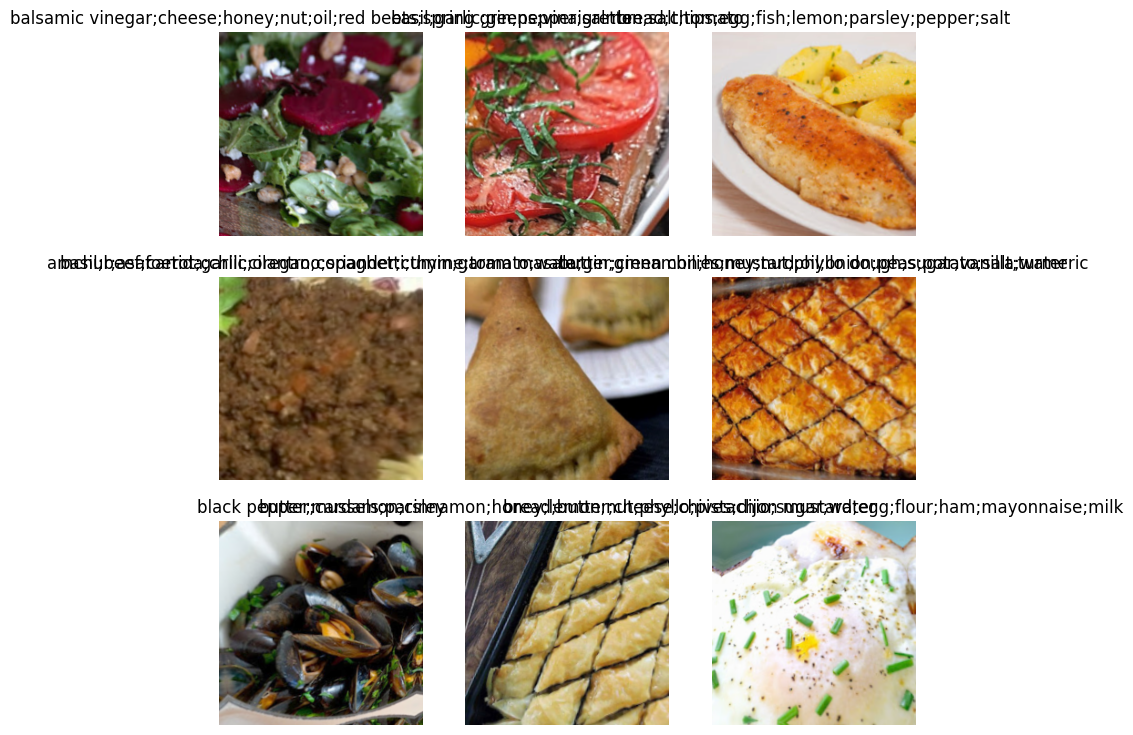

In [60]:
# Define paths to your dataset
annotations_path = Path('../data/Recipes5k/annotations/')
images_path = Path('../data/Recipes5k/images/')

# Function to read data from text files
def read_data(images_file, labels_file, ingredients_file):
    with open(annotations_path/images_file, 'r') as f:
        images = f.read().strip().split('\n')
    with open(annotations_path/labels_file, 'r') as f:
        index = f.read().strip().split('\n')
    with open(annotations_path/ingredients_file, 'r') as f:
        labels = f.read().strip().split('\n')

    # map the indez to the ingredients list (labels)
    ingredients = [labels[int(i)] for i in index]

    
    return pd.DataFrame({'image': images, 'label': ingredients, 'index': index})

# Load training, validation, and test data
train_df = read_data('train_images.txt', 'train_labels.txt', 'ingredients_simplified_Recipes5k.txt')
train_df = train_df[train_df['label'] != 'longaniza']
test_df = read_data('test_images.txt', 'test_labels.txt', 'ingredients_simplified_Recipes5k.txt')
test_df = test_df[test_df['label'] != 'longaniza']
valid_df = read_data('val_images.txt', 'val_labels.txt', 'ingredients_simplified_Recipes5k.txt')
valid_df = valid_df[valid_df['label'] != 'longaniza']

# Merge all data into one DataFrame
def splitter(df):
    train_idx = df.index[df['set'] == 'train'].tolist()
    test_idx = df.index[df['set'] == 'test'].tolist()
    valid_idx = df.index[df['set'] == 'valid'].tolist()
    return train_idx, test_idx, valid_idx

full_df = pd.concat([train_df.assign(set='train'), valid_df.assign(set='valid'), test_df.assign(set='test')])

# Create a DataBlock
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=lambda x: images_path/x['image'],  # Adjust path as necessary
                   get_y=lambda x: x['label'].split(','),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms(size=224))

# Create a DataLoaders object
dls = dblock.dataloaders(full_df, bs=32)

# Check if everything is loaded correctly
dls.show_batch()

In [61]:
full_df.tail()


,image,label,index,set
778,chocolate_ice_cream/41_homemade_chocolate_ice_cream_hostedLargeUrl.jpg,"chocolate,egg,sugar,vanilla,chocolate,milk",4817,test
779,chocolate_ice_cream/29_chocolate_ice_cream_hostedLargeUrl.jpg,"whipping,condensed milk,chocolate",4805,test
780,"chocolate_ice_cream/39_vanilla_bean,_white_chocolate_and_oreo_crumble_ice_cream_hostedLargeUrl.jpg","milk,sugar,whipping,vanilla,beans,chocolate,oreo\u00ae cookies",4815,test
781,chocolate_ice_cream/13_homemade_chocolate_ice_cream_hostedLargeUrl.jpg,"condensed milk,milk,chocolate,cocoa,corn starch,water,vanilla,salt",4789,test
782,chocolate_ice_cream/14_the_very_best_chocolate_ice_cream_hostedLargeUrl.jpg,"milk,cocoa,chocolate,vanilla,sugar,egg",4790,test


In [62]:
# check if label longaniza is in the ingredients
full_df['label'].apply(lambda x: 'longaniza' in x).sum()

1

## Tensorboard Integration

In [63]:
# class TensorBoardCallback(Callback):
#     def __init__(self, log_dir):
#         self.log_dir = log_dir
#         self.writer = None

#     def before_fit(self):
#         """ Set up the SummaryWriter before fitting the model """
#         self.writer = SummaryWriter()

#     def after_batch(self):
#         """ Log loss and other metrics after each batch """
#         if self.training:
#             self.writer.add_scalar('Loss/Train', self.loss.item(), self.train_iter)

#     def after_epoch(self):
#         """ Log validation metrics after each epoch """
#         for name, value in zip(self.learn.recorder.metric_names[1:-1], self.learn.recorder.log[1:-1]):
#             self.writer.add_scalar(f'{name}/Epoch', value, self.epoch)

#     def after_fit(self):
#         """ Close the writer after fitting """
#         self.writer.close()


## Model Training

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [65]:
def create_vit_model(num_classes):
    # Load a pre-trained Vision Transformer model without the classification head
    model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=0)

    # Number of features from the transformer blocks
    n_features = model.num_features

    # Replace the classifier head with a new one suited to the number of output classes
    model.head = nn.Sequential(
        nn.Linear(n_features, 512),  # Dimension reduction
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes),  # Ensure this matches your dataset's number of classes
        nn.Sigmoid()  # Use Sigmoid for multi-label classification
    )
    return model

# Specify the number of classes based on your dataset labels
num_classes = len(dls.vocab)  # Set this to match the number of unique labels/classes
vit_model = create_vit_model(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model = vit_model.to(device)

In [66]:
# Test Model Input-Output
x, y = dls.one_batch()
print('Input batch shape:', x.shape)
print('Output labels shape:', y.shape)

# Create Learner
learn = Learner(dls, vit_model, metrics=partial(accuracy_multi, thresh=0.2))

# Preview what the model outputs with one batch
print('Model output shape:', learn.model(x).shape)

Input batch shape: torch.Size([32, 3, 224, 224])
Output labels shape: torch.Size([32, 919])
Model output shape: torch.Size([32, 919])


In [74]:
# Assume 'dls' and 'vit_model' are already defined from your model setup
from fastai.callback.tensorboard import TensorBoardCallback

cbs = [TensorBoardCallback(log_dir='runs',)]
learn = Learner(dls.to(device), vit_model, metrics=partial(accuracy_multi, thresh=0.2), cbs=cbs)
learn.fine_tune(20, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.693141,0.693089,0.011646,00:33


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.693142,0.693093,0.011646,00:33
1,0.693139,0.693095,0.011646,00:33
2,0.693140,0.693099,0.011646,00:33
3,0.693140,0.693099,0.011646,00:34
4,0.693140,0.693104,0.011646,00:33
5,0.693141,0.693114,0.011646,00:34
6,0.693137,0.693099,0.011646,00:34
7,0.693133,0.693089,0.011646,00:34
8,0.693136,0.693092,0.011646,00:34
9,0.693133,0.693083,0.011646,00:34
